# Вариант 9

Рассматривается система линейных гиперболических уравнений:

\begin{gather*}
    \frac { \partial \mathbf { u } } { \partial t } + \mathbf { A } \frac { \partial \mathbf { u } } { \partial x } = \mathbf { b } ( x ) , ~ 0 \leqslant x \leqslant 1, ~ 0 \leqslant t \leqslant 1, ~~ 
    \mathbf { u } ( x , 0 ) = \left( \begin{array} { c } { 2 x - x ^ { 3 } } \\ { x ^ { 3 } } \\ { x ^ { 2 } + 1 } \end{array} \right) \\
    \mathbf { A } = \left( \begin{array} { c c c } { - 21 / 2 } & { 27 / 2 } & { 3 / 2 } \\ { - 7 } & { 9 } & { 1 } \\ { 13 / 2 } & { - 19 / 2 } & { - 3 / 2 } \end{array} \right), ~~ 
    \mathbf { b } ( x ) = \left( \begin{array} { l } { 0 } \\ { 0 } \\ { 0 } \end{array} \right)
\end{gather*}

Привести систему к характеристическому виду, предложить корректную постановку граничных условий.

Решить численно систему уравенний с использованием двух указанных схем.
Для каждой из схем выписать первое дифференциальное приближение (ПДП), 
определить, диссипативная или дисперсионная ошибка преобладает.
Монотонна ли схема? Оценить апостериорно порядок сходимости каждой схемы.

### Разностные схемы
Схемы приводятся для модельного уравнения $ \frac { \partial u } { \partial t } + a \frac { \partial u } { \partial x } = 0 , ~ a = \text { const } > 0 $ на сетке $ x _ { m } = m h , ~ m = 0 \dots M , ~ M h = 1 ; ~ t ^ { n } = n \tau , ~ n = 0 \dots N, ~ N \tau = 1 $. При необходимости преобразовать схемы для случая $ a = \text{const} < 0 $.

1) "Неявный" правый уголок (схема бегущего счета)
\begin{equation}
    \frac { u _ { m } ^ { n + 1 } - u _ { m } ^ { n } } { \tau } + a \frac { u _ { m + 1 } ^ { n + 1 } - u _ { m } ^ { n + 1 } } { h } = 0
\end{equation}

2) Центральная схема второго порядка (Лакса-Вендроффа, МакКормака)
\begin{equation}
    \frac { u _ { m } ^ { n + 1 } - u _ { m } ^ { n } } { \tau } + a \frac { u _ { m + 1 } ^ { n } - u _ { m - 1 } ^ { n } } { 2 h } = \frac { a ^ { 2 } \tau } { 2 } \frac { u _ { m + 1 } ^ { n } - 2 u _ { m } ^ { n } + u _ { m - 1 } ^ { n } } { h ^ { 2 } }
\end{equation}

## Анализ системы
Приведем систему к характеристическому виду. Для этого найдем левые собственные вектора (см. код ниже), затем приведем систему к каноническому виду. Это реализовано ниже.

In [1]:
# Подготовительный этап
from IPython.display import display, Math, Latex, Markdown
import pprint
import sympy as sp
from sympy import Matrix, Rational, latex, symbols
import numpy as np
from scipy.linalg import eig
x, u, t = sp.symbols('x u t')

In [2]:
# Вбиваем данные задачи
A = Matrix([
    [Rational(-21, 2), Rational(27, 2), Rational(3, 2)], 
    [-7, 9, 1], 
    [Rational(13, 2), Rational(-19, 2), Rational(-3, 2)]
])
#A = sp.diag(10, 5, 30)
b = Matrix([0, 0, 0])
u = Matrix([x + x**3, x**3, x**2 + 1])

In [3]:
# Ищем собственные вектора и собственные значения
print('Собственные значения и собственные вектора:')
tmp = A.T.eigenvects()
# Выводим это на экран
for i, tup in enumerate(tmp):
    display(Math(
        '\lambda_{0} = {1}; ~ \omega_{0} = {2}'
        .format( str(i+1), tup[0], latex(tup[2][0]) )
    ))

Собственные значения и собственные вектора:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [4]:
# Считаем матрицы, которые нам потом пригодятся
Omega = Matrix([Matrix(i[2][0]).T for i in tmp])
lambdas = [i[0] for i in tmp]
Lambda = sp.diag(*lambdas)

In [5]:
display(Latex(r'Запишем матрицу перехода: $ \Omega = {}$'.format(latex(Omega))),
        Latex(r'а также обратную ей: $ \Omega^{{-1}} = {}$'.format(latex(Omega**(-1)))),
        Math(r'A = \Omega^{-1} \Lambda \Omega')
       )

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

In [6]:
I = Omega*u
I_funcs = [sp.lambdify(x, I[i]) for i in range(Omega.shape[0])]
display(
    Math(r'\mathbf{{I}} (x, 0) = {}, ~~~~ \Lambda = {}'
         .format( latex(I), latex(Lambda) )
        )
)

<IPython.core.display.Math object>

#### О постановке граничных условий:
В нашей системе есть 0 положительных собственных значений, 1 нулевое и 2 
отрицательных. 
Значит, на левой границе не нужно ставить граничных условий, на правой же границе нужно 2.
В нулевом значении достаточно задать только начальное условие.

Попробуем поставить граничные условия вида:

\begin{equation}
u|_{t = 0} = f(x), ~~ u|_{x = 1} = g(t)
\end{equation} 

На них будет наложено необходимое условие разрешимости:
$ f(1) = g(0) $.
Потребуем также, чтобы производная не терпела разрыв: $ f'(1) = g'(0) $. Итого:

\begin{gather}
    \boxed{
    f(1) = g(0) \\
    f'(1) = g'(0)
    }
\end{gather}

In [14]:
display(
    Markdown('Итак, мы получили {} уравнения:'.format(Lambda.shape[0])),
    *[
        Math( 
            (r'\cfrac{{\partial I_{i} }} {{\partial t}} {sign}{koeff}\cdot'+ 
             r'\cfrac{{\partial I_{i} }} {{\partial x}} = {left_part}' +
             ', ~ I_{i} (x, 0) =' 
            ).format(
                i=(k+1), 
                sign='+' if lambdas[k] >= 0 else '-',
                koeff=abs(lambdas[k]),
                size=Lambda.shape[0],
                left_part=b[k]
            )
            + sp.latex( (Omega*u)[k] )
        ) for k in range(Lambda.shape[0])
    ]
)

Итак, мы получили 3 уравнения:

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Последнее уравнение решается просто:
\begin{equation*}
    I _ { 3 } ( x , t ) = \frac { x ^ { 3 } } { 3 } - \frac { 2 x } { 3 }
\end{equation*}

In [15]:
def make_grid(x_min, x_max, t_min, 
              t_max, h, tau, fictive_x=True):
    if fictive_x:
        x_grid = np.arange(x_min-h/2, x_max+h/2+h/4, h/2)
    else:
        x_grid = np.arange(x_min, x_max+h/4, h/2)
    t_grid = np.arange(t_min, t_max+tau/2, tau)
    # Матрица решений
    T = np.zeros((x_grid.shape[0], t_grid.shape[0]))
    return T, x_grid, t_grid

## Решение схемой неявного правого уголка
Данная схема преобразуется к виду:

\begin{equation}
    u_m^{n+1} (1 - \sigma) + \sigma u_{m+1}^{n+1} = u_m^n, ~~ \sigma = \frac{a \tau}{h}
\end{equation}

Здесь нам придется на каждой итерации решать систему из линейных уравений:
\begin{gather*}
    \mathbf{A} u^{n+1} = \mathbf{b} \\
    A = 
        \begin{bmatrix}
            1-\sigma & \sigma & 0 & \dots & 0 \\
            0 & 1-\sigma & \sigma & \dots & 0 \\
            \dots & \dots & \dots & \dots & \dots \\
            0 & \dots & 0 & 1-\sigma & \sigma
        \end{bmatrix}, ~~
    b = 
    \begin{bmatrix}
        u_{-1}^n \\ u_0^n \\ \dots \\ u_{M-1}^n
    \end{bmatrix}
\end{gather*}

In [16]:
from numba import jit

@jit(nopython=True)
def count_current_x_layer(T, n, sigma):
    # А все следующие пересчитываются через предыдущие
    # спасибо A.A. за наводку
    for m in range(T.shape[0]-2, -1, -1):
        T[m, n+1] = 1/(1-sigma)*T[m,n] - sigma/(1-sigma)*T[m+1,n+1]
    
def ugolok_kernel(T, sigma):
    """
    Предполагается, что граничные условия УЖЕ заданы
    """
    
    M, N = T.shape[0], T.shape[1]
    for n in range(0, N-1):
        # Решим систему и запишем результаты в следующую итерацию времени
        count_current_x_layer(T, n, sigma)
    # Выкинем фиктивные узлы в возвращаемом значении
    return T[1:-1, :]

In [17]:
def calculate_all_ugolok(timezero_funcs, xzero_funcs, a, h, tau, 
                    x_min=0, x_max=1, t_min=0, t_max=1):
    tmp = []
    for i in range(len(timezero_funcs)):
        func_t, func_x, a_curr = timezero_funcs[i], xzero_funcs[i], np.float64(a[i])
        # Создаем сетку
        T, x_grid, t_grid = make_grid(x_min, x_max, t_min, 
                                   t_max, h, tau, fictive_x=True)
        # Начальные условия
        T[:,0] = func_t(x_grid)
        # Граничные условия
        T[-1,:] = func_x(t_grid)
        T = T.astype('double')
        # Высчитываем sigma
        sigma = np.double(a_curr*tau/h)
        # Вызываем калькулятор
        mm = ugolok_kernel(T, sigma)
        tmp.append(
            [mm, x_grid[1:-1], t_grid]  # Выкинем наши фиктивные узлы
        )
    return tmp

In [18]:
h, tau = 10**-3, 10**-3/4
T, x, t = [], [], []

In [19]:
#xzero_funcs = [lambda x: np.ones_like(x), lambda x: np.ones_like(x), lambda x: np.zeros_like(x)]
xzero_funcs = [
    lambda t: np.sin(10*t)+I_funcs[0](1),
    lambda t: np.sin(10*t)+I_funcs[1](1),
    lambda t: np.sin(10*t)+I_funcs[2](1)
]
tmp = calculate_all_ugolok(I_funcs, xzero_funcs, lambdas, h, tau)

Counting for u_1...
Counting for u_2...
Counting for u_3...


In [20]:
for i, tup in enumerate(tmp):
    T.append(tup[0].T)
    x, t = tup[1], tup[2]
T = np.array(T)

In [21]:
omega_rev = np.array(Omega**-1).astype(np.float64)
solution = T.T.dot(omega_rev)

In [22]:
u_1 = solution[:,:,0]
u_2 = solution[:,:,1]
u_3 = solution[:,:,2]

In [23]:
# Строим анимацию для первого графика

import matplotlib.pyplot as plt
from matplotlib import animation
fig, ax = plt.subplots(figsize=(17,10))

line, = ax.plot(x, u_1[:,0], label='Решение')
initial, = ax.plot(x, u_1[:,0], label='Начальное условие')
#ax.set_ylim([u_1.min()-0.1, u_1.max()+0.1])
ax.set_ylim([-10, 10])
ax.title.set_text('Численное решение $u_1(t, x)$')
ax.set_xlabel("x")
ax.set_ylabel('$u_1(t, x)$')
ax.legend()
ax.grid()


def init():  # only required for blitting to give a clean slate.
    line.set_ydata([np.nan] * len(x))
    initial.set_ydata([np.nan] * len(x))
    return line, initial,


def animate(i):
    line.set_ydata(u_1[:,i*10])  # update the data.
    initial.set_ydata(u_1[:,0])  # update the data.x
    return line, initial,


ani = animation.FuncAnimation(
    fig, animate, init_func=init, interval=30, blit=True, save_count=(u_1.shape[1]-1)/10)

# To save the animation, use e.g.
#
ani.save("movie_ugol_u1.mp4")
#
# or
#
#from matplotlib.animation import FFMpegWriter
#writer = FFMpegWriter(fps=200, metadata=dict(artist='Me'), bitrate=1800)
#ani.save("movie1.mp4", writer=writer)


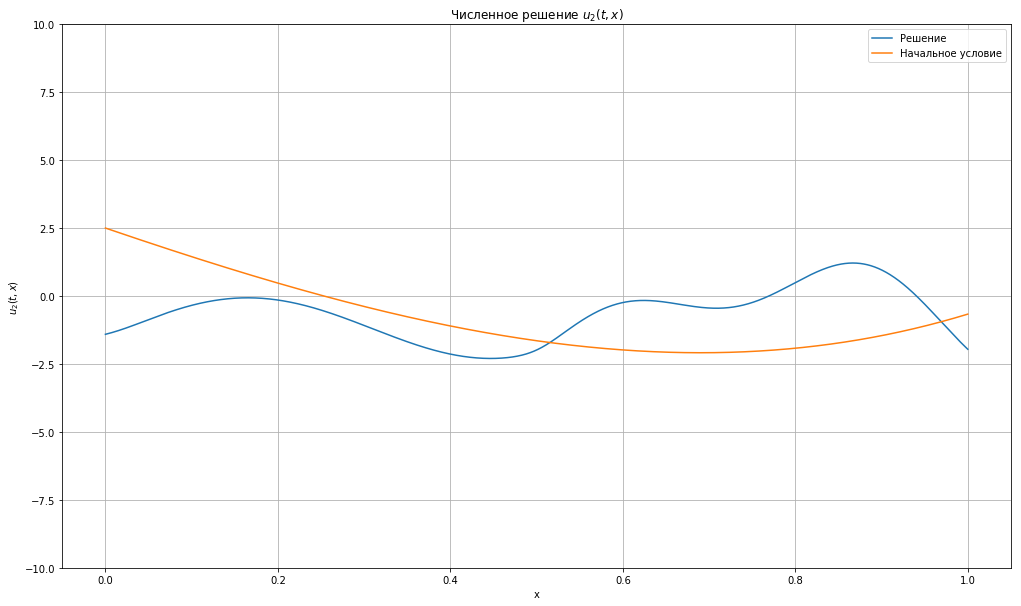

In [24]:
# Строим анимацию для второго графика

import matplotlib.pyplot as plt
from matplotlib import animation
fig, ax = plt.subplots(figsize=(17,10))

line, = ax.plot(x, u_2[:,0], label='Решение')
initial, = ax.plot(x, u_2[:,0], label='Начальное условие')
#ax.set_ylim([u_2.min()-0.1, u_2.max()+0.1])
ax.set_ylim([-10, 10])
ax.title.set_text('Численное решение $u_2(t, x)$')
ax.set_xlabel("x")
ax.set_ylabel('$u_2(t, x)$')
ax.legend()
ax.grid()


def init():  # only required for blitting to give a clean slate.
    line.set_ydata([np.nan] * len(x))
    initial.set_ydata([np.nan] * len(x))
    return line, initial,


def animate(i):
    line.set_ydata(u_2[:,i*10])  # update the data.
    initial.set_ydata(u_2[:,0])  # update the data.
    return line, initial,


ani = animation.FuncAnimation(
    fig, animate, init_func=init, interval=30, blit=True, save_count=(u_2.shape[1]-1)/10)

# To save the animation, use e.g.
#
ani.save("movie_ugol_u2.mp4")
#
# or
#
#from matplotlib.animation import FFMpegWriter
#writer = FFMpegWriter(fps=200, metadata=dict(artist='Me'), bitrate=1800)
#ani.save("movie1.mp4", writer=writer)


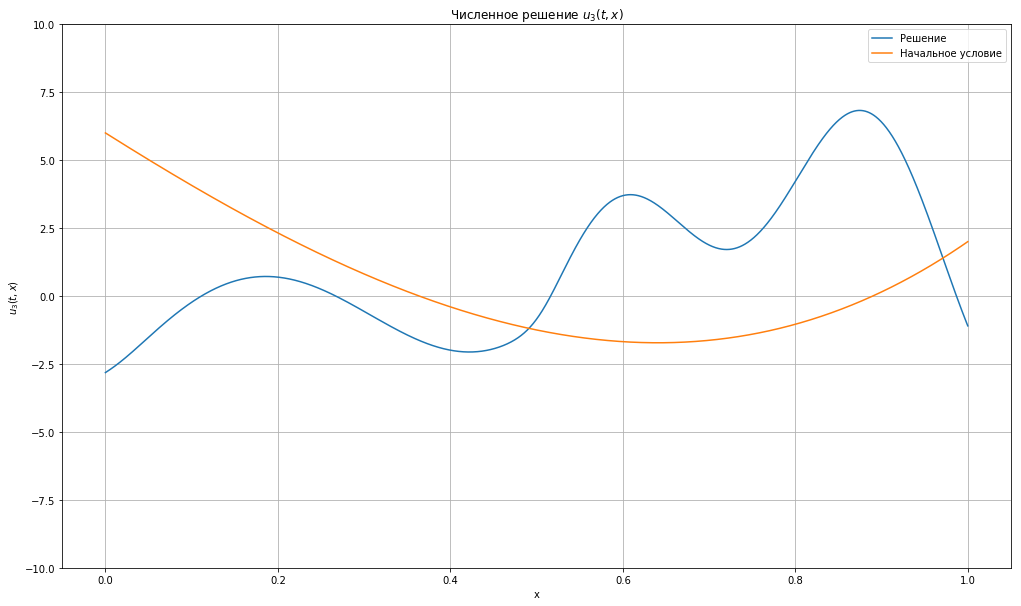

In [25]:
# Строим анимацию для третьего графика

import matplotlib.pyplot as plt
from matplotlib import animation
fig, ax = plt.subplots(figsize=(17,10))

line, = ax.plot(x, u_3[:,0], label='Решение')
initial, = ax.plot(x, u_3[:,0], label='Начальное условие')
#ax.set_ylim([u_3.min()-0.1, u_3.max()+0.1])
ax.set_ylim([-10, 10])
ax.title.set_text('Численное решение $u_3(t, x)$')
ax.set_xlabel("x")
ax.set_ylabel('$u_3(t, x)$')
ax.legend()
ax.grid()


def init():  # only required for blitting to give a clean slate.
    line.set_ydata([np.nan] * len(x))
    initial.set_ydata([np.nan] * len(x))
    return line, initial,


def animate(i):
    line.set_ydata(u_3[:,i*10])  # update the data.
    initial.set_ydata(u_3[:,0])  # update the data.
    return line, initial,


ani = animation.FuncAnimation(
    fig, animate, init_func=init, interval=30, blit=True, save_count=(u_3.shape[1]-1)/10)

# To save the animation, use e.g.
#
ani.save("movie_ugol_u3.mp4")
#
# or
#
#from matplotlib.animation import FFMpegWriter
#writer = FFMpegWriter(fps=200, metadata=dict(artist='Me'), bitrate=1800)
#ani.save("movie1.mp4", writer=writer)


## Решение центральной схемой второго порядка

Данная схема преобразуется к виду:
\begin{equation*}
    u _ { n } ^ { n + 1 } = u _ { m } ^ { n } - \frac { a \tau } { 2 h } \left( u _ { m + 1 } ^ { n } - u _ { m - 1 } ^ { n } \right) + \frac { a ^ { 2 } \tau ^ { 2 } } { 2 h ^ { 2 } } \left( u _ { m + 1 } ^ { n } - 2 u _ { m } ^ { n } + u _ { m - 1 } ^ { n } \right)
\end{equation*}
Мы введем два фиктивных узла по сетке $x$ (слева и справа). На каждой итерации по $n$ (время) значения в фиктивных узлах будем пересчитывать через линейную интерполяцию по двум предыдущим точкам (поскольку $h$ мало, это должно хватить).

In [26]:
from numba import jit
@jit(nopython=True, parallel=True)
def laks_kernel(T, sigma):
    """
    Основной калькулятор. Предполагается, что в `T` уже включены начальные данные.
    НАЧАЛЬНЫЕ УСЛОВИЯ ЗАДАНЫ СПРАВА!!! Я не хочу реализовывать это для начальных условий слева :)
    """
    M, N = T.shape[0], T.shape[1]
    for n in range(0, N-1):
        for m in range(1, M-1):
            T[m, n+1] = T[m, n] - sigma/2*(T[m+1, n] - T[m-1, n]) \
            + sigma**2/2* (T[m+1, n] - 2*T[m, n] + T[m-1, n])
        # Линейная экстраполяция слева
        T[0, n+1] = 2*T[1, n+1] - T[2, n+1]
        # А вот справа у нас уже есть начальные условия
        # Линейная экстраполяция справа
        #T[M-1, n+1] = 2*T[M-2, n+1] - T[M-3, n+1]
    return T[1:-1,:]

In [27]:
def calculate_all_laks(timezero_funcs, xzero_funcs, a, h, tau, 
                    x_min=0, x_max=1, t_min=0, t_max=1):
    tmp = []
    for i in range(len(timezero_funcs)):
        t_func, x_func, a_curr = timezero_funcs[i], xzero_funcs[i], np.float64(a[i])
        # Создаем сетку
        T, x_grid, t_grid = make_grid(x_min, x_max, t_min, 
                                   t_max, h, tau, fictive_x=True)
        T[:,0] = t_func(x_grid)
        T[-1,:] = x_func(t_grid)
        T = T.astype('double')
        # Высчитываем sigma
        sigma = np.double(a_curr*tau/h)
        # Вызываем Лакаса
        mm = laks_kernel(T, sigma)
        tmp.append(
            [mm, x_grid[1:-1], t_grid]  # Выкинем наши фиктивные узлы
        )
        del mm
    return tmp

In [28]:
h, tau = 10**-3, 10**-3/4

In [29]:
T, x, t = [], [], []
timezero_funcs = I_funcs
# Пока попробуем выполнить необходимые условия
xzero_funcs = [
    lambda t: np.sin(10*t)+I_funcs[0](1),
    lambda t: np.sin(10*t)+I_funcs[1](1),
    lambda t: np.sin(10*t)+I_funcs[2](1)
]
tmp = calculate_all_laks(timezero_funcs, xzero_funcs, 
                         lambdas, h, tau)

In [30]:
for i, tup in enumerate(tmp):
    T.append(tup[0].T)
    x, t = tup[1], tup[2]
T = np.array(T)
del tmp

In [31]:
omega_rev = np.array(Omega).astype(np.double)**(-1)

C:\Users\aleks\Miniconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in reciprocal
  """Entry point for launching an IPython kernel.


In [32]:
#omega_rev = np.array(Omega**-1).astype(np.float64)
solution = T.T.dot(omega_rev)

In [33]:
u_1 = solution[:,:,0]
u_2 = solution[:,:,1]
u_3 = solution[:,:,2]

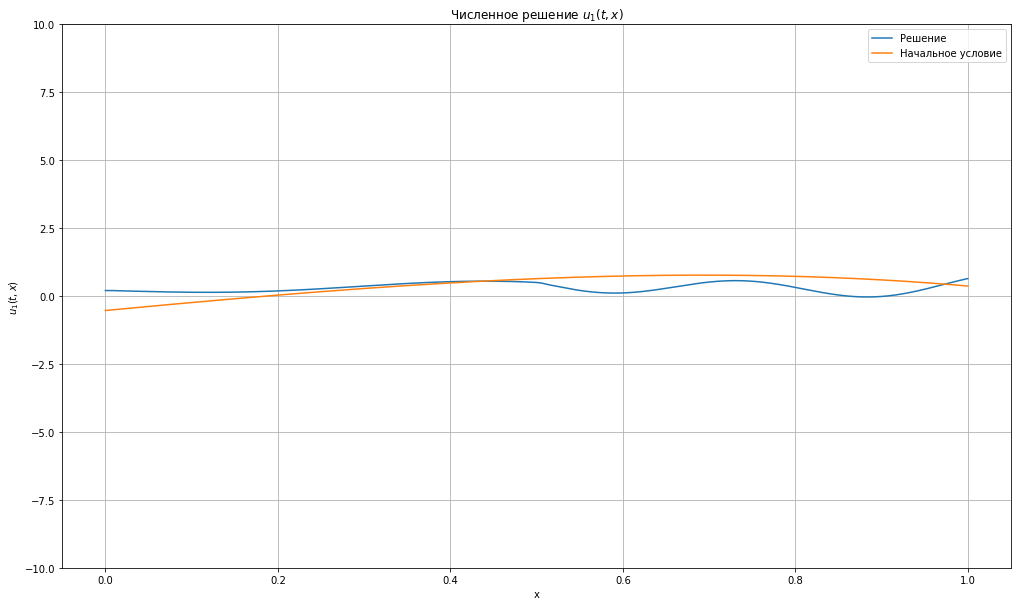

In [34]:
# Строим анимацию для первого графика

import matplotlib.pyplot as plt
from matplotlib import animation
fig, ax = plt.subplots(figsize=(17,10))

line, = ax.plot(x, u_1[:,0], label='Решение')
initial, = ax.plot(x, u_1[:,0], label='Начальное условие')
#ax.set_ylim([u_1.min()-0.1, u_1.max()+0.1])
ax.set_ylim([-10, 10])
ax.title.set_text('Численное решение $u_1(t, x)$')
ax.set_xlabel("x")
ax.set_ylabel('$u_1(t, x)$')
ax.legend()
ax.grid()


def init():  # only required for blitting to give a clean slate.
    line.set_ydata([np.nan] * len(x))
    initial.set_ydata([np.nan] * len(x))
    return line, initial,


def animate(i):
    line.set_ydata(u_1[:,i*10])  # update the data.
    initial.set_ydata(u_1[:,0])  # update the data.x
    return line, initial,


ani = animation.FuncAnimation(
    fig, animate, init_func=init, interval=30, blit=True, save_count=(u_1.shape[1]-1)/10)

# To save the animation, use e.g.
#
ani.save("movie_laks_u1.mp4")
#
# or
#
#from matplotlib.animation import FFMpegWriter
#writer = FFMpegWriter(fps=200, metadata=dict(artist='Me'), bitrate=1800)
#ani.save("movie1.mp4", writer=writer)


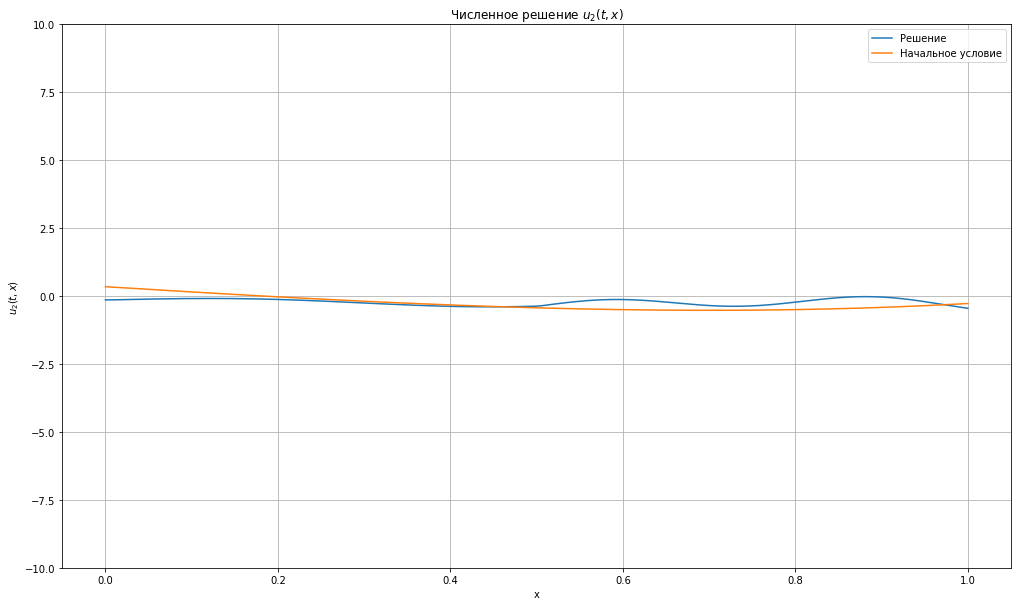

In [35]:
# Строим анимацию для второго графика

import matplotlib.pyplot as plt
from matplotlib import animation
fig, ax = plt.subplots(figsize=(17,10))

line, = ax.plot(x, u_2[:,0], label='Решение')
initial, = ax.plot(x, u_2[:,0], label='Начальное условие')
#ax.set_ylim([u_2.min()-0.1, u_2.max()+0.1])
ax.set_ylim([-10, 10])
ax.title.set_text('Численное решение $u_2(t, x)$')
ax.set_xlabel("x")
ax.set_ylabel('$u_2(t, x)$')
ax.legend()
ax.grid()


def init():  # only required for blitting to give a clean slate.
    line.set_ydata([np.nan] * len(x))
    initial.set_ydata([np.nan] * len(x))
    return line, initial,


def animate(i):
    line.set_ydata(u_2[:,i*10])  # update the data.
    initial.set_ydata(u_2[:,0])  # update the data.
    return line, initial,


ani = animation.FuncAnimation(
    fig, animate, init_func=init, interval=30, blit=True, save_count=(u_2.shape[1]-1)/10)

# To save the animation, use e.g.
#
ani.save("movie_laks_u2.mp4")
#
# or
#
#from matplotlib.animation import FFMpegWriter
#writer = FFMpegWriter(fps=200, metadata=dict(artist='Me'), bitrate=1800)
#ani.save("movie1.mp4", writer=writer)


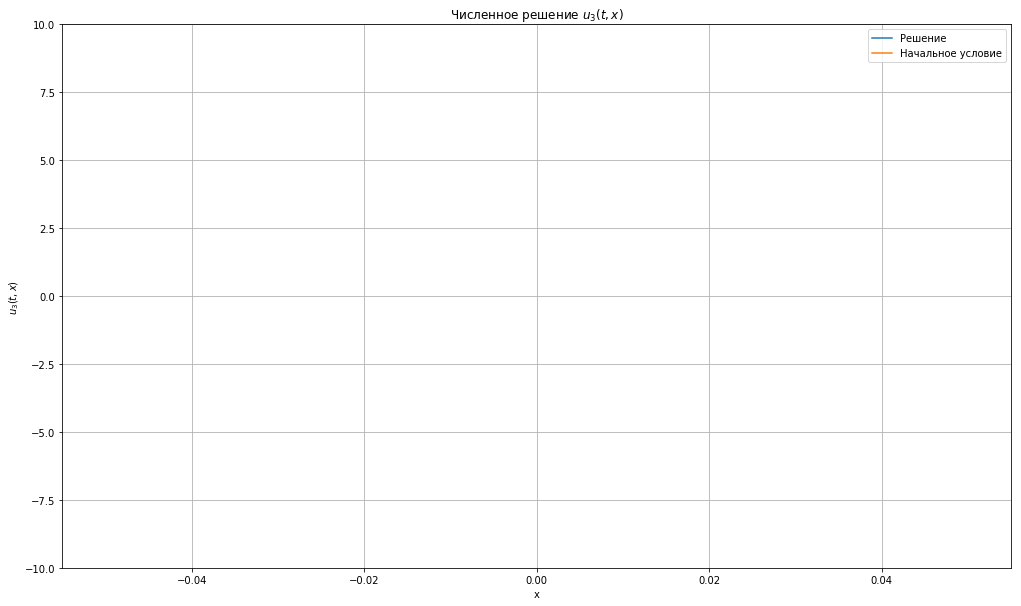

In [36]:
# Строим анимацию для третьего графика

import matplotlib.pyplot as plt
from matplotlib import animation
fig, ax = plt.subplots(figsize=(17,10))

line, = ax.plot(x, u_3[:,0], label='Решение')
initial, = ax.plot(x, u_3[:,0], label='Начальное условие')
#ax.set_ylim([u_3.min()-0.1, u_3.max()+0.1])
ax.set_ylim([-10, 10])
ax.title.set_text('Численное решение $u_3(t, x)$')
ax.set_xlabel("x")
ax.set_ylabel('$u_3(t, x)$')
ax.legend()
ax.grid()


def init():  # only required for blitting to give a clean slate.
    line.set_ydata([np.nan] * len(x))
    initial.set_ydata([np.nan] * len(x))
    return line, initial,


def animate(i):
    line.set_ydata(u_3[:,i*10])  # update the data.
    initial.set_ydata(u_3[:,0])  # update the data.
    return line, initial,


ani = animation.FuncAnimation(
    fig, animate, init_func=init, interval=30, blit=True, save_count=(u_3.shape[1]-1)/10)

# To save the animation, use e.g.
#
ani.save("movie_laks_u3.mp4")
#
# or
#
#from matplotlib.animation import FFMpegWriter
#writer = FFMpegWriter(fps=200, metadata=dict(artist='Me'), bitrate=1800)
#ani.save("movie1.mp4", writer=writer)
